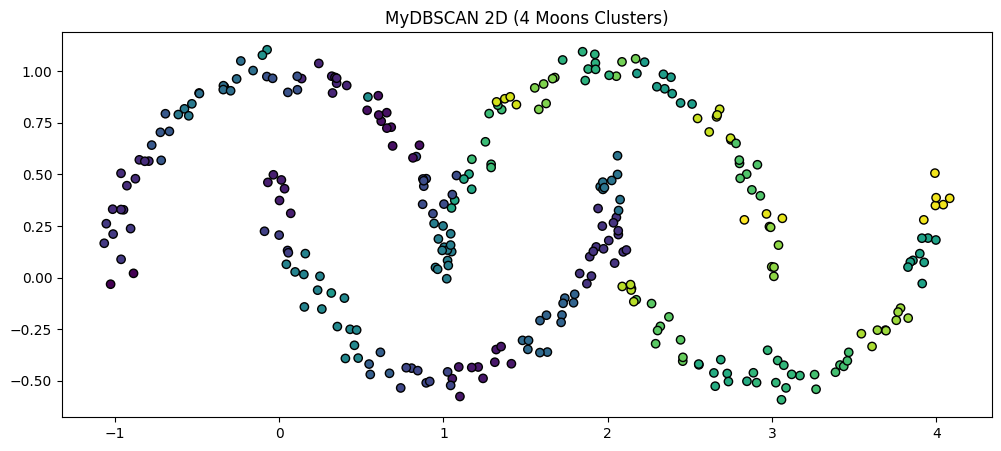

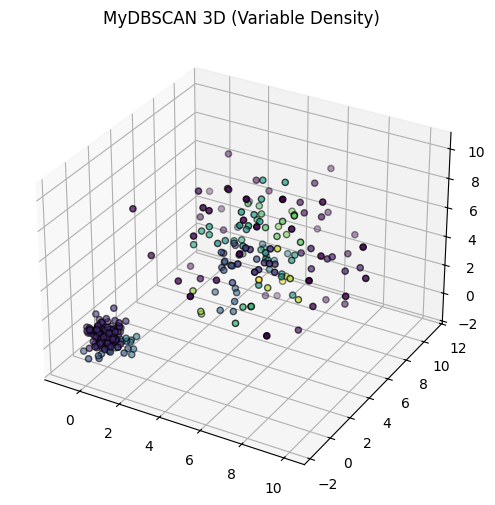

silhouette_score for MyDBSCAN 2D: 0.33747393213487853
silhouette_score for MyDBSCAN 3D: 0.04692967163877122
davies_bouldin_score for MyDBSCAN 2D: 0.6216053041587304
davies_bouldin_score for MyDBSCAN 3D: 2.1835464054820988
calinski_harabasz_score for MyDBSCAN 2D: 1137.9409248138797
calinski_harabasz_score for MyDBSCAN 3D: 62.324407656825166
silhouette_score for KMeans 2D: 0.4237490360927155
silhouette_score for KMeans 3D: 0.6849135881945921
davies_bouldin_score for KMeans 2D: 0.8233118926419036
davies_bouldin_score for KMeans 3D: 0.4520088537503195
calinski_harabasz_score for KMeans 2D: 499.101362715591
calinski_harabasz_score for KMeans 3D: 913.2161950196813


/Users/aleksandrsnetkov/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/aleksandrsnetkov/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons, make_blobs
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Реализация DBSCAN
class MyDBSCAN:
    def __init__(self, eps=0.2, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = None
    
    def euclidean_distance(self, a, b):
        return np.sqrt(((a - b) ** 2).sum(axis=1))
    
    def fit(self, X):
        X = np.array(X)
        labels = np.full(len(X), -1)  # -1 означает шум
        cluster_id = 0
        
        for i in range(len(X)):
            if labels[i] != -1:
                continue
            neighbors = self.region_query(X, i)
            if len(neighbors) < self.min_samples:
                continue
            cluster_id += 1
            self.expand_cluster(X, labels, i, neighbors, cluster_id)
        
        self.labels = labels
    
    def region_query(self, X, index):
        return [i for i in range(len(X)) if distance.euclidean(X[i], X[index]) < self.eps]
    
    def expand_cluster(self, X, labels, index, neighbors, cluster_id):
        labels[index] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor = neighbors[i]
            if labels[neighbor] == -1:  # Шум становится частью кластера
                labels[neighbor] = cluster_id
            elif labels[neighbor] == 0:
                labels[neighbor] = cluster_id
                new_neighbors = self.region_query(X, neighbor)
                if len(new_neighbors) >= self.min_samples:
                    neighbors.extend(new_neighbors)
            i += 1
    
    def predict(self):
        return self.labels

# 1. Генерация 4 кластеров в 2D с make_moons
X_moons_1, _ = make_moons(n_samples=150, noise=0.05, random_state=42)
X_moons_2, _ = make_moons(n_samples=150, noise=0.05, random_state=43)
X_moons_2[:, 0] += 2  # Смещение по X для разделения кластеров
X_2D = np.vstack((X_moons_1, X_moons_2))  # Объединяем два набора

# 2 кластера в 3D с разной плотностью
X_3D, _ = make_blobs(n_samples=300, centers=[[0, 0, 0], [5, 5, 5]], cluster_std=[0.5, 2.0], n_features=3, random_state=42)

# 2. Кластеризация DBSCAN
my_dbscan_2D = MyDBSCAN(eps=0.2, min_samples=5)
my_dbscan_2D.fit(X_2D)
labels_2D = my_dbscan_2D.predict()

my_dbscan_3D = MyDBSCAN(eps=1.5, min_samples=5)
my_dbscan_3D.fit(X_3D)
labels_3D = my_dbscan_3D.predict()

# 3. Визуализация результатов
plt.figure(figsize=(12, 5))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=labels_2D, cmap='viridis', edgecolors='k')
plt.title("MyDBSCAN 2D (4 Moons Clusters)")
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:, 0], X_3D[:, 1], X_3D[:, 2], c=labels_3D, cmap='viridis', edgecolors='k')
ax.set_title("MyDBSCAN 3D (Variable Density)")
plt.show()

# 4. Оценка качества кластеризации
metrics = [silhouette_score, davies_bouldin_score, calinski_harabasz_score]

for metric in metrics:
    try:
        dbscan_2D_score = metric(X_2D, labels_2D) if len(set(labels_2D)) > 1 else -1
        dbscan_3D_score = metric(X_3D, labels_3D) if len(set(labels_3D)) > 1 else -1
        print(f"{metric.__name__} for MyDBSCAN 2D: {dbscan_2D_score}")
        print(f"{metric.__name__} for MyDBSCAN 3D: {dbscan_3D_score}")
    except:
        pass

# 5. Сравнение с KMeans
kmeans_2D = KMeans(n_clusters=4, random_state=42).fit(X_2D)
kmeans_3D = KMeans(n_clusters=2, random_state=42).fit(X_3D)

for metric in metrics:
    try:
        kmeans_2D_score = metric(X_2D, kmeans_2D.labels_)
        kmeans_3D_score = metric(X_3D, kmeans_3D.labels_)
        print(f"{metric.__name__} for KMeans 2D: {kmeans_2D_score}")
        print(f"{metric.__name__} for KMeans 3D: {kmeans_3D_score}")
    except:
        pass
